In [6]:
import os,pickle,numpy as np
from PIL import Image    #PIL is Python Image Library
from cv2 import cv2
import matplotlib.pyplot as plt


In [4]:

f_f = 0
p_p = 0

face_cascade=cv2.CascadeClassifier('cascades/data/haarcascade_frontalface_alt2.xml')

image_dir=os.path.join(r'C:\Users\ELSOUDY\faces\Faces\train')

image_id=0
label_id={}
y_train_label=[]
x_train_data=[]


for root,dirs,files in os.walk(image_dir):
   
    for file in files:
        
        if(file.endswith('png') or file.endswith('jpg')):
            path=os.path.join(root,file)
            label=os.path.basename(root).replace(' ','_').lower()
            p_p +=1
            
            if(label not in label_id):  #Assinging numbers to labels(LabelEncoding)
                label_id[label]=image_id
                image_id+=1



            pil_image=Image.open(path).convert('L')  #Coverting into grayscale.
            
            size=(400,533)
            final_image=pil_image.resize(size,Image.ANTIALIAS)

            image_array=np.array(final_image)  #Convert the gray_scale image into an array of pixels.
            

            faces = face_cascade.detectMultiScale(image_array, scaleFactor=1.2, minNeighbors=5)
            for x,y,w,h in faces:
                f_f +=1
                roi_gray = image_array[y:y+h, x:x+w]    #Pixel values of the face region.
                
                y_train_label.append(label_id[label])         #Appending the label number
                x_train_data.append(roi_gray)               #Appending the pixel values of the label face


                
print(p_p)
print(f_f)

1598
998


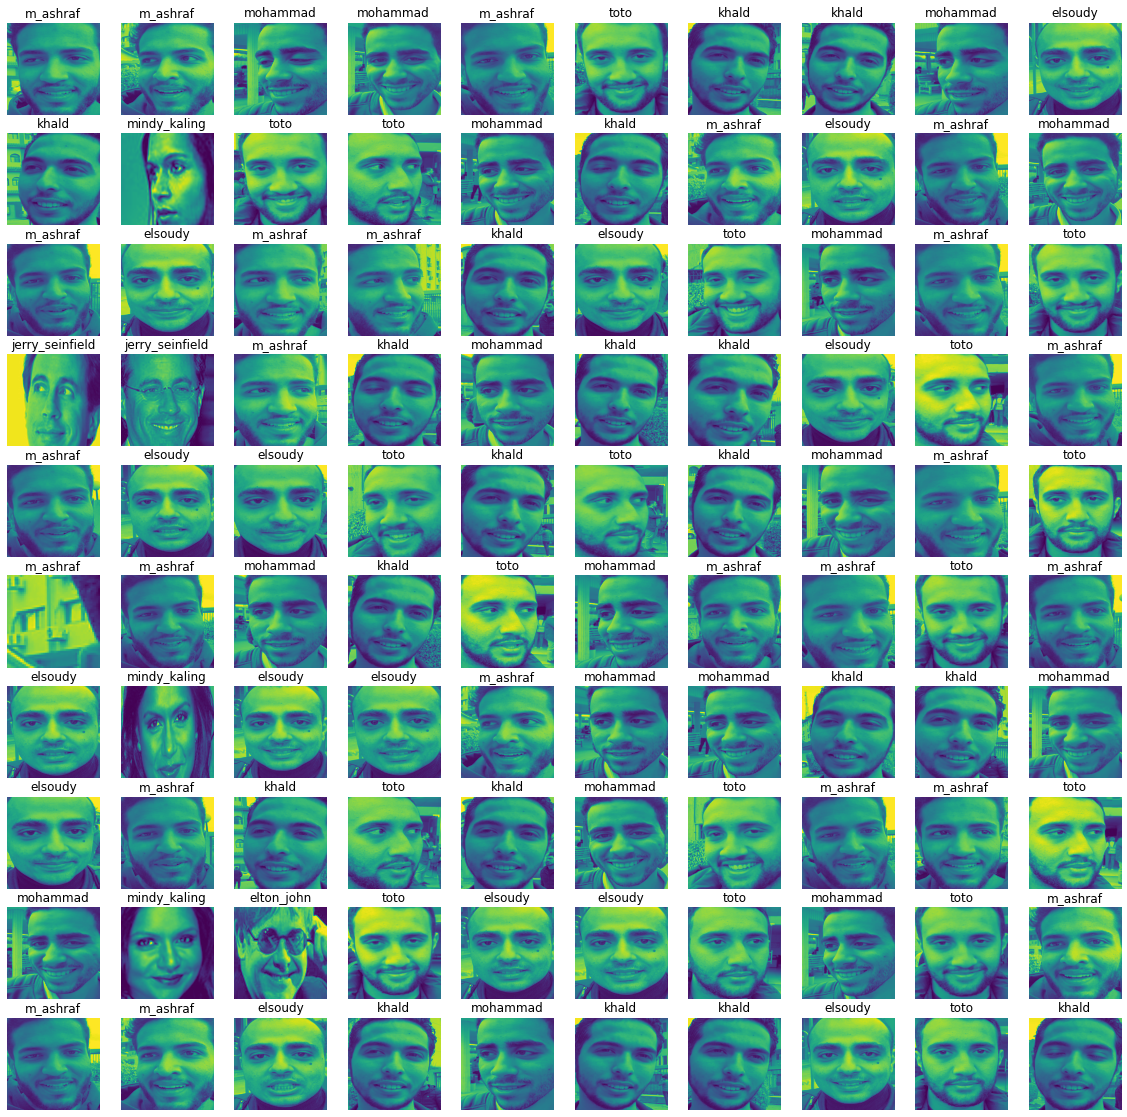

In [57]:
plt.figure(figsize=(20,20))
for n,i in enumerate(np.random.randint(0,len(x_train_data),100)):
    plt.subplot(10,10,n+1)
    plt.imshow(x_train_data[i])
    plt.axis('off')
    for key,value in label_id.items():
        if value == y_train_label[i]:
            x=key
    plt.title(x)

In [59]:
with open('label_ids.pickle','wb') as fw:
    pickle.dump(label_id,fw)
    
recognizer=cv2.face.LBPHFaceRecognizer_create()
recognizer.train(x_train_data,np.array(y_train_label))
recognizer.save('trainer.yml')
print ("Done")

Done


In [3]:
import pickle,time
from cv2 import cv2
import pyttsx3   #offline lib for tts
import serial

face_cascade=cv2.CascadeClassifier('cascades/data/haarcascade_frontalface_alt2.xml')
recognizer = cv2.face.LBPHFaceRecognizer_create()
recognizer.read('trainer.yml')

engine = pyttsx3.init() 
with open("label_ids.pickle",'rb') as fr:    
    og_labels=pickle.load(fr)
labels={k:v for v,k in og_labels.items()}
print(labels)

{0: 'ben_afflek', 1: 'elsoudy', 2: 'elton_john', 3: 'jerry_seinfield', 4: 'khald', 5: 'm_ashraf', 6: 'madonna', 7: 'mindy_kaling', 8: 'mohammad', 9: 'toto'}


In [4]:
def speak(text):  #fn to convert text to speech
    engine.say(text)
    engine.runAndWait() 

def face_recognition():
    flag_face_recognised=False   #to keep track if the user face is recognized
    flag_face_not_recognised=False

    no_of_adjacent_prediction=0
    no_face_detected=0  #to track the number of times the face is detected
    prev_predicted_name=''   #to keep track of the previously predicted face(w.r.t frame)
    cap=cv2.VideoCapture(0)
    count_frames = total_no_face_detected = 0





    while True:
        count_frames+=1
        ret,frame = cap.read()
        # print(ret,frame)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        faces=face_cascade.detectMultiScale(gray,scaleFactor=1.2,minNeighbors=5)

        # print("FACES : ",faces)
        # print(type(frame))   #The frames are automatically converted into numpy arrays of pixels.
        for (x,y,w,h) in faces:

            total_no_face_detected+=1
            no_face_detected+=1

            # print(x,y,w,h)
            roi_gray=gray[y:y+h,x:x+w]  #roi(region of interest)
            # roi_color=frame[y:y+h,x:x+w]
            id,confidence=recognizer.predict(roi_gray)
            print(id,confidence)
            if(confidence>70):
                #print("PREDICTED : ",labels[id])
                font=cv2.FONT_HERSHEY_SIMPLEX
                name=labels[id]
                clr=(255,255,255);thickness=2
                cv2.putText(frame,name.replace('_',' ').title(),(x,y-5),font,0.8,clr,1,cv2.LINE_AA)

            
                if(prev_predicted_name==name):
                    no_of_adjacent_prediction+=1
                else:
                    no_of_adjacent_prediction=0

                prev_predicted_name=name        



            # color=(255,0,0) #BGR 0-255
            thickness=1
            end_coord_x=x+w
            end_coord_y=y+h


            if(no_of_adjacent_prediction>15):   #no_of_adjacent_prediction is only updated when the confidence of classification is >80
                cv2.putText(frame,"Welcome home "+name.replace('_',' ').title(),(160,460),font,0.8,clr,thickness,cv2.LINE_AA)  #to print on frame
                flag_face_recognised=True
                no_of_adjacent_prediction=0
                no_face_detected=0

            elif(no_face_detected>=30):
                cv2.putText(frame,"Face Not Recognised",(160,460),font,0.8,clr,thickness,cv2.LINE_AA)
                flag_face_not_recognised=True
                no_of_adjacent_prediction=0
                no_face_detected=0

            cv2.rectangle(frame,(x,y),(end_coord_x,end_coord_y),(0,0,0),2)  #Drawing the rectangle on the frame
            cv2.putText(frame,name.replace('_',' ').title(),(x,y-5),font,0.8,clr,1,cv2.LINE_AA)

        cv2.imshow('Face Recognition',frame)

        if(flag_face_recognised):    #if face is recognized then open the door
            speak("Welcome "+name.replace('_',' ')+", unlocking door. The door will remain open for the next 5 seconds")
            print("DOOR is OPEN")
            #arduino.write(bytes('o', 'utf-8'))  #Output the given byte string over the serial port.
            
            time.sleep(5)
            speak("Closing door")
            #arduino.write(bytes('c', 'utf-8'))  #Output the given byte string over the serial port.
            print("DOOR is CLOSED")
            flag_face_recognised=False

        if(flag_face_not_recognised):
            speak("Face not recognised. The door will remain closed")    
            time.sleep(2)
            flag_face_not_recognised=False


        k=cv2.waitKey(20)     #the key is recieved and converted into ascii value
        if k==113:  #compairing with the ordinal/ascii value of 'q'
            break
        
        elif cv2.waitKey(1) & 0xFF == ord('q'):
            break


    print("No. of frames : ",count_frames," |   No. of times face detected : ",total_no_face_detected)
    cap.release()
    cv2.destroyAllWindows()






In [5]:
if(__name__=="__main__"):
    face_recognition()    

1 57.302525282588086


UnboundLocalError: local variable 'name' referenced before assignment

In [16]:
face_recognition() 

1 50.1019308329918


UnboundLocalError: local variable 'name' referenced before assignment